In [31]:
#loading yeast groundtruth 0 data
yeast=open("yeast_residual_data_full_1000_gt_2.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]


In [32]:
#loading yeast groundtruth 1 data
yeast=open("yeast_residual_data_full_1000_gt_1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_1 = [i for i in zip(L,A,B)]

#reshapefunction



In [33]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2

In [21]:
#loading the rpy2 pacakge to use the R package nlcor
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
nlcor=importr('nlcor')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [5]:
#defining the class MDN
class MDN_module(tf.keras.Model):

    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [6]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [7]:
def compute_loss(P,Q):
  """ Compute the loss for the given pair
  """
  opt = tf.optimizers.Adam(1e-2)
  mdn_PQ = MDN_module()
  mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
  mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
  return eval_mdn_model(P,Q,mdn_PQ)


In [8]:
def shuffleBtimes(P,Q,B):
  """ Shuffle Q B times and compute the loss 
  """
  loss=[]
  for i in range(0,B):
      loss.append(compute_loss(P,np.random.permutation(Q)))
  return loss


In [57]:
def LinearLABData():
  """ Generate the linear data 
  """
  L = np.random.binomial(1,0.5,1000)  
  beta0 = np.ones(1000)-0.4
  #beta1 = 0.5
  beta1=3
  beta2= 0.3
  beta3=0.8
  eps0 = np.random.standard_normal(1000)
  eps1 = np.random.standard_normal(1000)
  A = beta0 + beta1*L + eps0
  B = beta2+ beta3*A + eps1 
  plt.scatter(A,B)
  plt.title("A vs B")
  plt.xlabel("A")
  plt.ylabel("B")
  return [L,A,B]

In [80]:
def residual(P,Q):
  """ Calculate the residual 
  """
  opt = tf.optimizers.Adam(1e-2)
  mdn_PQ = MDN_module()
  mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
  mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
  y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
  #model=sm.OLS(Q,P).fit() return model.resid #Linear residual
  #non linear residual
  print(y_pred)
  print(Q)
  print(Q-y_pred[:,0])
  return (Q-y_pred[:,0])
  

In [59]:
yeast_name=""
def yeast_data(i,ind):
    '''
    Function to return the trios with the gndtruth 0/1 based on i and the number based on ind 
    '''
    global yeast_name
    yeast_name="yeast_"+str(i)+"_"+str(ind)
    ds = eval("dataset_"+str(i)+"["+str(ind)+"]")
    L_dist = np.array(ds[0]) #np.array(ds[0])
    A_dist = np.array(ds[1])
    B_dist = np.array(ds[2])
    plt.scatter(A_dist,B_dist)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L_dist,A_dist,B_dist]

In [48]:
def calculate_pvalue(original,loss_list,test):
    '''
    calculate the p value 
    '''
    if(test==1 or test==2):
        return sum(i < original for i in loss_list)/len(loss_list)
    
    return sum(i > original for i in loss_list)/len(loss_list)
    

In [45]:
def stratify_B_n_times(L,A,B,n):
    '''
    Stratify B wrt to L
    '''
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
      
      B_dist_temp=np.zeros(len(B))
      mod_indices_1=random.sample(indices_1,len(indices_1))
      for i in range(len(indices_1)):
        B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

      mod_indices_0=random.sample(indices_0,len(indices_0))
      for i in range(len(indices_0)):
        B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
      loss.append(compute_loss(L,residual(A,B_dist_temp)))

    return loss 




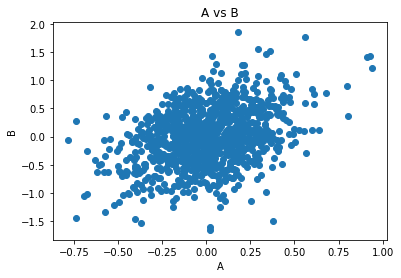

In [60]:
random.seed(24)
shuffles=10
#L,A,B=LinearLABData()
L,A,B=yeast_data(1,444)


In [81]:

A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles)
loss_list_Bresidual=stratify_B_n_times(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
true_LA=compute_loss(L,A)
true_LB=compute_loss(L,B)
true_LBresidual=compute_loss(L,residual(A,B))
print(calculate_pvalue(true_LA,loss_list_LA,1))
print(calculate_pvalue(true_LB,loss_list_LB,2))
print(calculate_pvalue(true_LBresidual,loss_list_Bresidual,3))
#true_LindB_A=compute_loss(L,B_resid)


[[ 1.          0.21549964  0.4932338 ]
 [ 1.          0.04293688  0.47826403]
 [ 1.         -0.01895968  0.44529462]
 ...
 [ 1.          0.04533006  0.4793102 ]
 [ 1.          0.31730005  0.49075752]
 [ 1.          0.09998875  0.49358726]]
[-0.4944018  -0.48745416  0.14591189 ...  0.0318627  -0.38148647
 -0.06058811]
[-1.4944018  -1.48745416 -0.85408811 ... -0.9681373  -1.38148647
 -1.06058811]
[[ 1.          0.17154889  0.5081367 ]
 [ 1.          0.0154406   0.490712  ]
 [ 1.         -0.06024096  0.448761  ]
 ...
 [ 1.          0.01735686  0.4918236 ]
 [ 1.          0.26499522  0.5060144 ]
 [ 1.          0.04778766  0.504752  ]]
[-0.4944018  -0.48745416  0.14591189 ...  0.0318627  -0.38148647
 -0.06058811]
[-1.4944018  -1.48745416 -0.85408811 ... -0.9681373  -1.38148647
 -1.06058811]
[[ 1.          0.16452067  0.5116096 ]
 [ 1.         -0.01135474  0.48161495]
 [ 1.         -0.09121214  0.4449469 ]
 ...
 [ 1.         -0.00792155  0.4831835 ]
 [ 1.          0.25784302  0.5156642 ]
 [ 1

In [69]:
loss_list_LB

[0.74681723,
 0.74853647,
 0.7494433,
 0.74988216,
 0.74885696,
 0.74878865,
 0.7499578,
 0.7490468,
 0.7473355,
 0.74946165]

In [27]:
yeast_name 

'yeast_1_444'

In [109]:
pickle_items=[loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A]
file_name=str(shuffles)+"shuffles"+yeast_name+".pkl"
open_file = open(file_name, "wb")
pickle.dump(pickle_items, open_file)
open_file.close()


In [37]:
file_name="100shufflesyeast_1_444.pkl"
open_file = open(file_name, "rb")

loaded_list = pickle.load(open_file)

open_file.close()

In [41]:
loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A=loaded_list

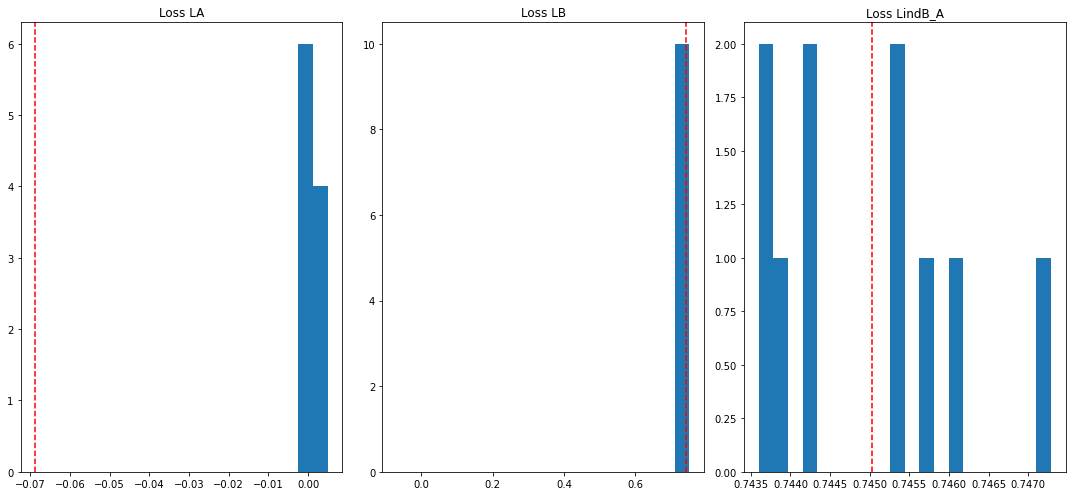

In [82]:
basket=20
fig, axs = plt.subplots(1, 3,figsize =(15, 7),tight_layout = True)
axs[0].hist(loss_list_LA,bins=basket,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LA),true_LA)])
axs[0].set_title("Loss LA")
axs[0].axvline(true_LA,linestyle='dashed',color='red')
axs[1].hist(loss_list_LB,bins=basket,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LB),true_LB)])
axs[1].set_title("Loss LB")
axs[1].axvline(true_LB,linestyle='dashed',color='red')
axs[2].hist(loss_list_Bresidual,bins=basket)#,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LindB_A),true_LindB_A)])
axs[2].set_title("Loss LindB_A")
axs[2].axvline(true_LBresidual,linestyle='dashed',color='red')
plt.show()

In [36]:
true_LA


-0.068573